```python
## \file src/webdriver/llm_driver/simple_browser.py
# -*- coding: utf-8 -*-
#! .pyenv/bin/python3
```
Модуль для запуска задач с использованием LLM через LangChain и стандартных агентов.
==================================================================================
(Использует инструменты, взаимодействующие с BrowserController и/или API поиска)

Предоставляет функциональность для:
- Конфигурирования моделей (Gemini, OpenAI).
- Установки API ключей.
- Запуска задачи с использованием LLM и доступных инструментов (веб-поиск, браузер).
- Выполнения задачи до конечного результата (`run_task`).
- Стриминга выполнения задачи (`stream_task`).

Зависимости:
    - langchain-openai, langchain-google-genai, langchain-core, langchainhub, langchain
    - langchain-community (для SerpAPIWrapper)
    - google-search-results (для SerpAPIWrapper)
    - python-dotenv
    - browser_use (или ваш модуль с BrowserController)
    - src.gs, src.logger, src.utils, header
```rst
.. module:: src.webdriver.llm_driver.simple_browser
```

In [1]:
import ipdb # <- трасировка и точки останова
import os,sys
import asyncio
from types import SimpleNamespace
from typing import List, Dict, Any, Optional, Callable, Type, Tuple, AsyncIterator
from pathlib import Path

# LangChain компоненты
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import AgentExecutor, create_react_agent, Tool
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.exceptions import LangChainException
from langchain import hub
# --- Инструмент для поиска через API ---
# Убедитесь, что установлена: pip install google-search-results
from langchain_community.utilities import SerpAPIWrapper
from browser_use import Agent

# --- Внутренние модули ---
import header
from header import __root__
from src import gs
# from src.webdriver.ai_browser import tools
# from src.webdriver.ai_browser.tools import get_tools, get_tools_by_type, get_tools_by_name
from src.webdriver.llm_driver.use_llm import Config, Driver, stream_agent_execution

from src.logger import logger
from src.utils.jjson import j_loads, j_loads_ns
from src.utils.printer import pprint as print

from dotenv import load_dotenv
load_dotenv()

INFO     [browser_use] BrowserUse logging setup complete with level info
INFO     [telemetry] Anonymized telemetry enabled. See https://docs.browser-use.com/development/telemetry for more information.
INFO     [numexpr.utils] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO     [numexpr.utils] NumExpr defaulting to 8 threads.
WARNING  [logger_console] ⚠️ Error fetching data from git: https://api.github.com/repos/hypotez/hypo/releases/latest
 response.status_code=404 
INFO     [logger_console] ℹ️ Асинхронные контроллеры успешно импортированы из src.webdriver.llm_driver.controllers. 
WARNING  [logger_console] ⚠️ .env файл не найден по пути: C:\Users\user\Documents\repos\hypotez\.env. 
INFO     [logger_console] ℹ️ Конфигурация успешно загружена из C:\Users\user\Documents\repos\hypotez\src\webdriver\llm_driver\use_llm.json 
INFO     [logger_console] ℹ️ Config Gemini: Status=active, Model=gemini-2.5-flash-preview-04-17, Key Present=True 


False

In [2]:
class Config:
    ENDPOINT:Path = Path(__root__/'SANDBOX'/'davidka')

In [3]:
class SimpleDriver(Driver):
    """"""
    def __init__(self, 
                 GEMINI_API_KEY:str = None, 
                 OPENAI_API_KEY:str = None, 
                 openai_model_name:str = None, 
                 gemini_model_name:str = None, 
                 start_browser:str = True,
                **kwargs):
        super().__init__(GEMINI_API_KEY, OPENAI_API_KEY, openai_model_name, gemini_model_name, start_browser, **kwargs) 

    async def simple_process_task_async(self, task:str = 'Hello, world!') -> Any:
        """"""

        result_dict:dict = {}

        def clean_json(raw_text: str) -> str:
            # 1. Убираем всё до первой фигурной скобки {
            try:
                json_start = raw_text.index('{')
            except Exception as ex:
                logger.error("Ошибка поиска первой фигурной скобки", ex, exc_info=True)
                return ''
            if json_start == -1:
                return raw_text  # нет скобки, вернуть как есть
            # Извлекаем текст начиная с первой фигурной скобки
            json_cleaned = raw_text[json_start:]
    
            # 2. Убираем завершающие тройные кавычки или лишние пробелы
            json_cleaned = json_cleaned.strip('`\n ')
            
            return json_cleaned

        try:
            # Инициализация агента с списком моделей и задачей
            # Убедитесь, что ваш класс Agent может принимать список LLM объектов в параметре 'llm'
            agent = Agent(
                task=task,
                llm=self.gemini, # Передача инициализированнoй модели
                # Другие параметры для Agent, если они есть
            )
            logger.info(f"Агент начинает выполнение задачи: \"{task}\"")
            # --- Перехват stdout ---
            original_stdout = sys.stdout
            sys.stdout = io.StringIO()

            try:
                answer = await agent.run()
            finally:
                sys.stdout = original_stdout  # Обязательно вернуть обратно!

            if not answer:
                logger.error('Не вернулся результат действий агента')
                ...
            answer: Any = await agent.run() # Ожидание результата работы агента
            if not answer:
                logger.error('Не вернулся результат действий агента')
                ...
            timestamp:str = gs.now

            for action_result in answer.history:
                result_list:list = getattr(action_result, 'result', None)
                result:'ActionResult' = result_list[0]
                extracted_content:str =	result.extracted_content

                cleaned_json_text = clean_json(extracted_content)
                try:
                    data = j_loads(cleaned_json_text)  # Загружаем JSON из текста
                    if not data: continue
                except Exception as ex:
                    logger.error("Ошибка разбора JSON", ex, exc_info=True)
                    ...
                    continue

                # Сохраняем данные
                timestamp = gs.now
                j_dumps(data, Config.ENDPOINT/'train_data_products'/f'product_links_{timestamp}.json')
                result_dict.update(data)

            logger.info("Агент завершил выполнение задачи.")
            ...
            return result_dict 
        except Exception as agent_err:
            logger.error(f"\n\n !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!/nПроизошла ошибка во время инициализации или выполнения задачи агентом./n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!/n", agent_err, exc_info=True)
            ...
            return '' # Возврат None при ошибке агента

```python
## \file /sandbox/davidka/crawler_simple_driver.py
# -*- coding: utf-8 -*-
#! .pyenv/bin/python3
```
Модуль для сбора данных со страниц товаров через SimpleDriver
=====================================================
(адаптация исходного crawler.py)
```rst
.. module:: sandbox.davidka.crawler_simple_driver
```


In [4]:
import asyncio
import random
from pathlib import Path

import header
from header import __root__
from src import gs
from src.webdriver.llm_driver.simple_driver import SimpleDriver
from src.utils.jjson import j_loads, j_dumps
from src.utils.file import read_text_file, save_text_file, get_filenames_from_directory
from src.utils.url import get_domain
from src.utils.string.ai_string_utils import normalize_answer
from src.utils.printer import pprint as print
from src.logger import logger

In [5]:
class Config:
    ENDPOINT: Path = __root__ / 'SANDBOX' / 'davidka'
    mining_data_path: Path = ENDPOINT / 'random_urls'
    train_data_supplier_categories_path: Path = ENDPOINT / 'train_data_supplier_categories'
    checked_domains: list = read_text_file(ENDPOINT / 'checked_domains.txt', as_list=True)
    crawl_files_list: list = get_filenames_from_directory(mining_data_path, 'json')
    instruction_grab_product_page_simple_driver: str = (ENDPOINT / 'instructions' / 'grab_product_page_simple_driver.md').read_text(encoding='utf-8')
    instruction_get_supplier_categories: str = (ENDPOINT / 'instructions' / 'get_supplier_categories.md').read_text(encoding='utf-8')
    instruction_find_product_in_supplier_domain: str = (ENDPOINT / 'instructions' / 'find_product_in_supplier_domain.md').read_text(encoding='utf-8')
    instruction_for_products_urls_one_product: str = (ENDPOINT / 'instructions' / 'get_product_links_one_product.md').read_text(encoding='utf-8')
    instruction_links_from_search: str = (ENDPOINT / 'instructions' / 'links_from_search.md').read_text(encoding='utf-8')
    instruction_links_from_searh_page: str = (ENDPOINT / 'instructions' / 'links_from_searh_page.md').read_text(encoding='utf-8')
    GEMINI_API_KEY = gs.credentials.gemini.katia.api_key
    driver: SimpleDriver = SimpleDriver(gemini_model_name='gemini-1.5-flash-8b-exp-0924', GEMINI_API_KEY = GEMINI_API_KEY)



INFO     [logger_console] ℹ️ --- Начало СИНХРОННОЙ инициализации Driver --- 
WARNING  [logger_console] ⚠️ OpenAI LLM не инициализирован (Key=True, Status=disabled, Model=True) 
INFO     [logger_console] ℹ️ Инициализация Gemini: Model=gemini-2.5-flash-preview-04-17 
INFO     [logger_console] ℹ️ Gemini LLM инициализирован. 
INFO     [logger_console] ℹ️ --- Синхронная инициализация Driver завершена. Вызовите async_init() --- 


In [6]:
def get_products_urls_list_from_files(crawl_files_list: list = None) -> list:
    """Читает файлы с продуктами и возвращает product_url списком"""
    products_urls_list = []
    for filename in crawl_files_list or Config.crawl_files_list:
        try:
            file_path = Config.mining_data_path / filename
            crawl_data = j_loads(file_path)['products']
            for product in crawl_data:
                products_urls_list.append(product['product_url'])
        except Exception as ex:
            logger.error(f'Ошибка при обработке файла {filename=}', ex, exc_info=True)
    random.shuffle(products_urls_list)
    return products_urls_list


def yield_product_urls_from_files(directory: Path = Config.mining_data_path, pattern: str = 'json'):
    """Генератор url продуктов из файлов"""
    filenames = get_filenames_from_directory(directory, pattern)
    for filename in filenames:
        try:
            file_path = directory / filename
            crawl_data = j_loads(file_path)['products']
            for product in crawl_data:
                yield product['product_url']
        except Exception as ex:
            logger.error(f'Ошибка при обработке файла {filename=}', ex, exc_info=True)


def get_categories_from_random_urls(crawl_files_list: list = None) -> list:
    """Возвращает все категории из файлов продуктов"""
    categories_list = []
    for filename in crawl_files_list or Config.crawl_files_list:
        try:
            file_path = Config.mining_data_path / filename
            crawl_data = j_loads(file_path)
            crawl_data = crawl_data.get('products', [])
            for product in crawl_data:
                if 'parent_category' in product:
                    categories_list.append(product['parent_category'])
                if 'category_name' in product:
                    categories_list.append(product['category_name'])
        except Exception as ex:
            logger.error(f'Ошибка при обработке файла {filename=}', ex, exc_info=True)
    categories_list = list(filter(None, set(categories_list)))
    random.shuffle(categories_list)
    return categories_list


async def get_products_urls(category: str, task:str = '', num_of_links: str = '10') -> str:
    """Получить товары по категории"""
    try:
        driver = Config.driver
        logger.info(f'Обработка {category=}')
        
        task = task or Config.instruction_links_from_searh_page.replace('{PRODUCT_CATEGORY}', category).replace('{NUM_LINKS}', num_of_links)
        #ipdb.set_trace()
        answer = await driver.simple_process_task_async(task)
        if not answer:
            return ''
        print('\n -------------------------------- EXTRACTED DATA \n------------------------------------------\n')
        print(answer)
        print('\n -------------------------------------------------------------------------------------------')
        return answer
    except Exception as ex:
        logger.error(f'Ошибка при обработке {category=}', ex, exc_info=True)
        return ''


async def fetch_categories_from_suppliers_random_urls() -> dict:
    """Сбор категорий с сайтов"""
    categories_dict = {}
    driver = Config.driver

    for filename in Config.crawl_files_list:
        try:
            file_path = Config.mining_data_path / filename
            crawl_data = j_loads(file_path)
            crawl_data = crawl_data.get('products', [])
            for product in crawl_data:
                domain = get_domain(product['product_url'])
                if domain in Config.checked_domains:
                    continue
                task = Config.instruction_get_supplier_categories.replace('{INPUT_URL}', domain)
                res = await driver.simple_process_task_async(task)
                if not res:
                    continue
                normalized_res = normalize_answer(res.get('output', ''))
                data = j_loads(normalized_res)
                print(data)
                j_dumps(data, Config.train_data_supplier_categories_path / f'{gs.now}.json')
                Config.checked_domains.append(domain)
                save_text_file(Config.checked_domains, Config.ENDPOINT / 'checked_domains.txt')
                j_dumps(Config.checked_domains, Config.ENDPOINT / 'checked_domains.json')
        except Exception as ex:
            logger.error(f'Ошибка при обработке файла {filename=}', ex, exc_info=True)
    return categories_dict

INFO     [logger_console] ℹ️ Обработка category='Molded Case Circuit Breakers (MCCB)' 
INFO     [agent] 🧠 Starting an agent with main_model=models/gemini-2.5-flash-preview-04-17 +vision, planner_model=None, extraction_model=None 
INFO     [logger_console] ℹ️ Агент начинает выполнение задачи: "
```md
**Роль:** Ты — Автоматизированный Веб-Агент для Поиска Страниц.

**Цель:**  
Найти **все ссылки** из первой страницы поиска по запросу `Molded Case Circuit Breakers (MCCB)`.

**Инструкция:**

1. **Открой поисковую систему** (например, Google, Bing или аналогичную).

2. 
- **Введи запрос**: `Molded Case Circuit Breakers (MCCB)`.

3. **Из результатов поиска**:

   - Собери **все ссылки** на первой странице поиска.
   - Пропускай рекламные и спонсорские результаты.
   - Пропускай ссылки на социальные сети и видеохостинги.

4. **Фильтрация ссылок**:
   - Игнорируй все ссылки, в домене которых содержатся следующие ключевые слова:
     - `youtube`
     - `tiktok`
     - `facebook`
     - `instagr
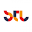
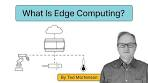
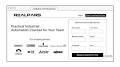
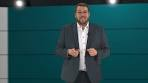
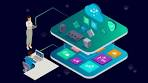
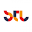
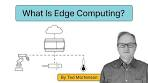
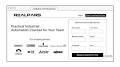
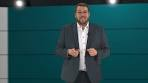
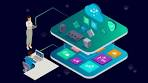
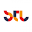
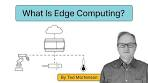
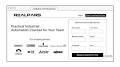
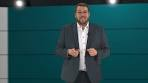
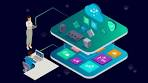
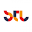
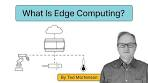
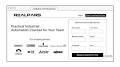
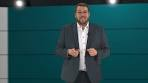
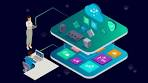
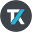
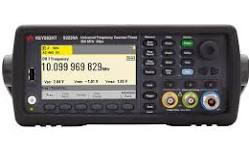
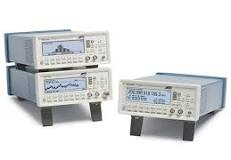
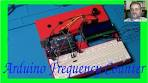
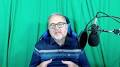
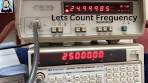
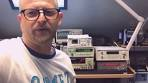
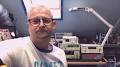
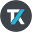
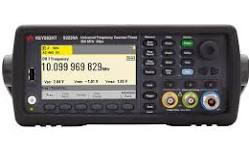
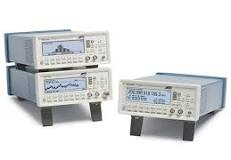
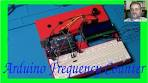
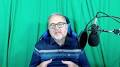
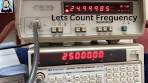
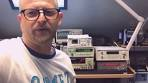
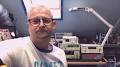
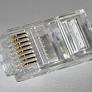
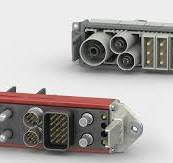
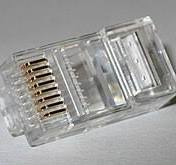
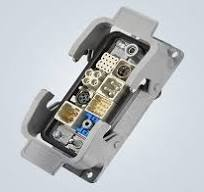
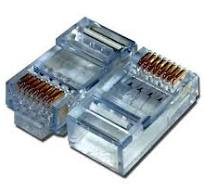
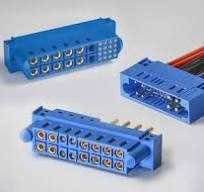
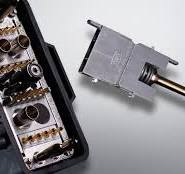
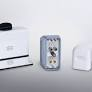

In [ ]:
driver = Config.driver

# Пример: обработка товаров по категориям
for category in get_categories_from_random_urls():
    #ipdb.set_trace()
    if not await get_products_urls(category = category, num_of_links = '10'):
        break